In [1]:
#! pip -q install pandas matplotlib
#! pip install -q scikit-learn
#! pip install -q joblib
#! pip install -q tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [3]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [4]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'precipitation', 'blackout', 'date', 'snow', 'school_holidays', 'mov_change', 'holiday', 'mini_shutdown', 'frankfurt_shutdown', 'holiday_name', 'shutdown', 'shops_closed', 'warehouse', 'winter_school_holidays'}
No differences found in column: precipitation
No differences found in column: blackout
No differences found in column: snow
No differences found in column: school_holidays
No differences found in column: mov_change
No differences found in column: holiday
No differences found in column: mini_shutdown
No differences found in column: frankfurt_shutdown
No differences found in column: holiday_name
No differences found in column: shutdown
No differences found in column: shops_closed
No differences found in column: winter_school_holidays

Success. All values match across the datasets, datasets merged.
{'date', 'school_holidays', 'holiday', 'holiday_name', 'shops_closed', 'warehouse', 'winter_school_holidays'}
No differences found in column: school_holidays
No differences found in col

In [5]:
train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

### Drop unnecesary data

There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [6]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['precipitation', 'blackout', 'snow', 'mov_change', 'mini_shutdown', 'user_activity_2', 'frankfurt_shutdown', 'warehouse_limited', 'shutdown', 'user_activity_1']


In [7]:
train_df = train_df.drop(columns=unavailable_features)
#train_df = train_df.drop(columns=['holiday_name']) # redundant
#test_df = test_df.drop(columns=['holiday_name']) # redundant

In [8]:
# list redundant columns that have unchanging values
unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

[]


In [9]:
print(train_df.columns)
print(f"train data: {train_df.shape}")
print(f"test data: {test_df.shape}")

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
train data: (7340, 9)
test data: (397, 8)


In [10]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
id                           0
dtype: int64
warehouse                   0
date                        0
holiday_name              380
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
dtype: int64


In [11]:
test_df.head()

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
61,Brno_1,2024-03-16,NaN,0,0,0,0,Brno_1_2024-03-16
340,Budapest_1,2024-03-16,NaN,0,0,0,0,Budapest_1_2024-03-16
292,Frankfurt_1,2024-03-16,NaN,0,0,0,0,Frankfurt_1_2024-03-16
244,Munich_1,2024-03-16,NaN,0,0,0,0,Munich_1_2024-03-16
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16


In [12]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


In [13]:
# merge the two datasets to facilitate data preprocessing and lag features generation   
train_df = pd.concat([train_df, test_df], axis=0)

In [14]:
train_df = train_df.sort_values(by=['date', 'warehouse'])

In [15]:
train_df.head(10)

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
1193,Brno_1,2020-12-05,6447.0,NaN,0,0,0,0,Brno_1_2020-12-05
6186,Budapest_1,2020-12-05,4623.0,NaN,0,0,0,0,Budapest_1_2020-12-05
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,Prague_1_2020-12-05
2386,Prague_2,2020-12-05,4154.0,NaN,0,0,0,0,Prague_2_2020-12-05
3579,Prague_3,2020-12-05,4091.0,NaN,0,0,0,0,Prague_3_2020-12-05
1194,Brno_1,2020-12-06,5338.0,NaN,0,0,0,0,Brno_1_2020-12-06
6187,Budapest_1,2020-12-06,4197.0,NaN,0,0,0,0,Budapest_1_2020-12-06
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,Prague_1_2020-12-06
2387,Prague_2,2020-12-06,4016.0,NaN,0,0,0,0,Prague_2_2020-12-06
3580,Prague_3,2020-12-06,3972.0,NaN,0,0,0,0,Prague_3_2020-12-06


In [16]:
# merge school_holiday and winter_schoolholiday into a single feature
#train_df['school_holiday'] = train_df['school_holidays'] | train_df['winter_school_holidays']
#train_df = train_df.drop(columns=['school_holidays', 'winter_school_holidays'])

In [17]:
def process_date(df):
    df.index = df.pop('date')
    
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['sin_month']=np.sin(2*np.pi*df['month']/12)
    df['cos_month']=np.cos(2*np.pi*df['month']/12)
    df['sin_day']=np.sin(2*np.pi*df['day']/30)
    df['cos_day']=np.cos(2*np.pi*df['month']/30)
    
    time_features = ['year', 'month', 'day', 'day_of_year', 'sin_month', 'cos_month', 'sin_day', 'cos_day']
    categorical_features = ['day_of_week', 'quarter'] 
    return df, time_features, categorical_features

### Features categories:
- time_features
- numerical_features
- categorical_features

In [18]:
train_df, time_features, categorical_features=process_date(train_df)

In [19]:
# train_df['holiday_name'].fillna('noholiday', inplace=True)

### Plot

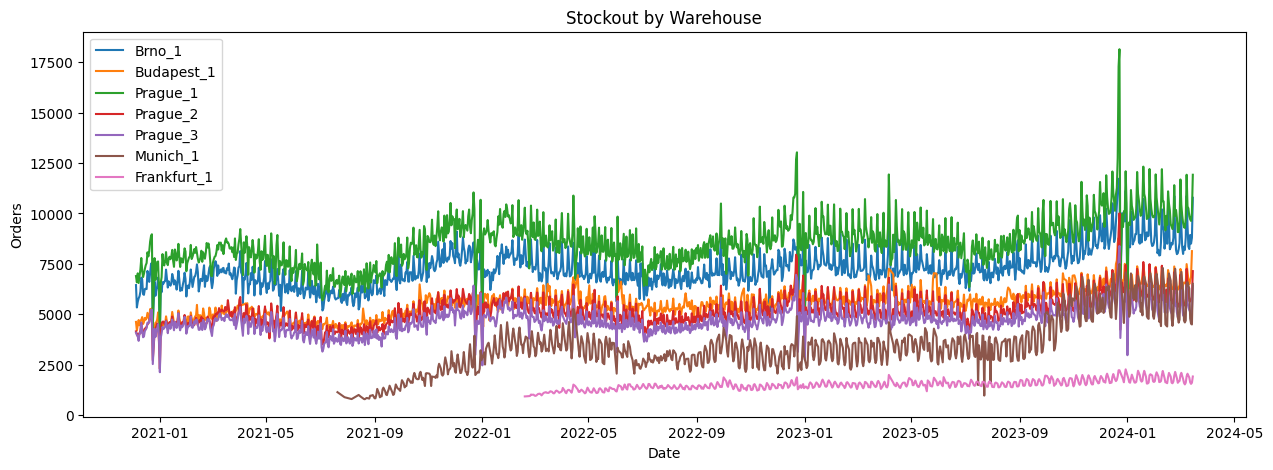

In [20]:
# Visualise the data
plt.figure(figsize=(15, 5))
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_df.index, warehouse_df['orders'], label=warehouse)
plt.title("Stockout by Warehouse")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

In [21]:
train_df['orders'].describe()

count     7340.000000
mean      5535.443869
std       2182.680279
min        790.000000
25%       4434.000000
50%       5370.000000
75%       7009.250000
max      18139.000000
Name: orders, dtype: float64

<Axes: title={'center': 'Distribution'}, xlabel='Orders', ylabel='Frequency'>

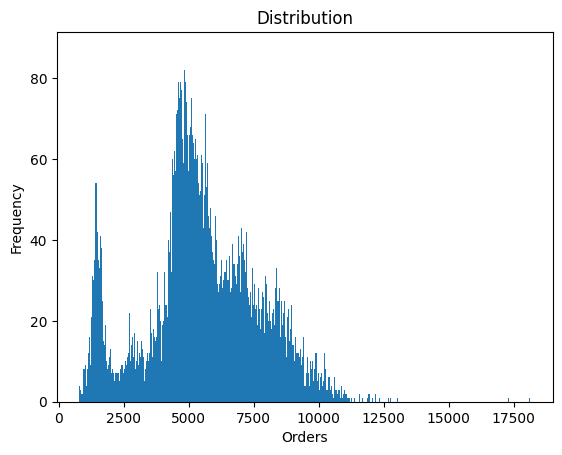

In [22]:
train_df['orders'].plot(kind='hist', bins=500, title='Distribution', xlabel='Orders')

<Axes: xlabel='date'>

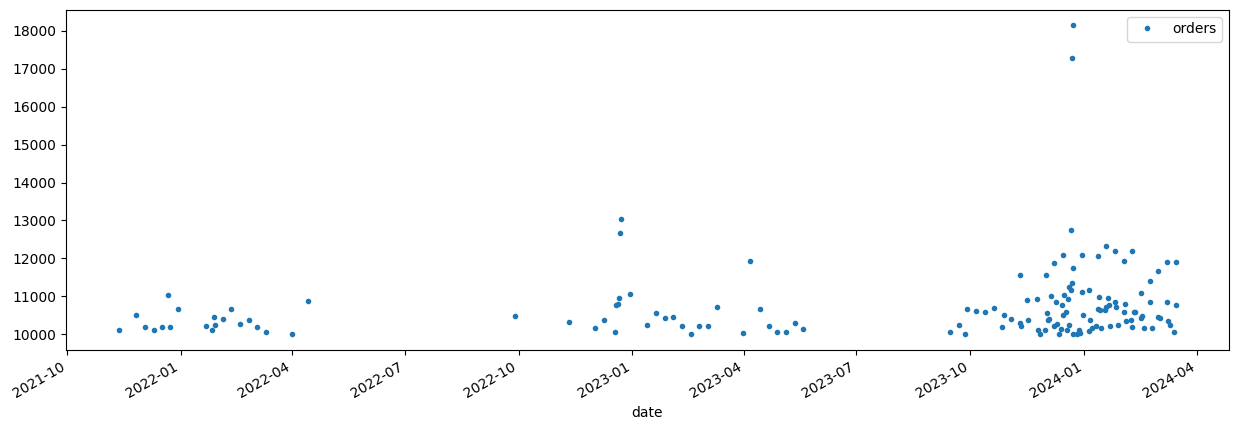

In [23]:
train_df.query('orders > 10000').plot(y='orders', figsize=(15, 5), style='.')

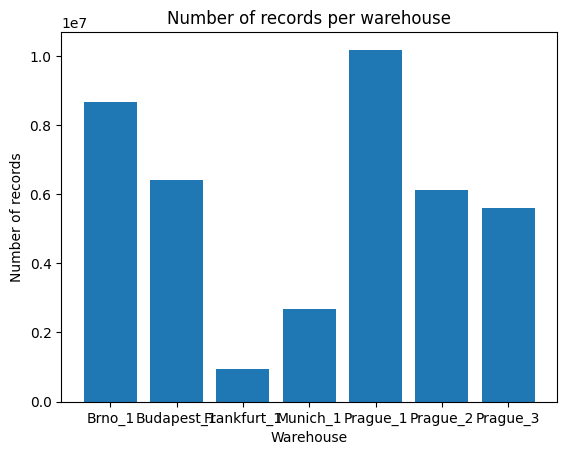

In [24]:
whs = train_df.groupby('warehouse')['orders'].sum()

plt.bar(whs.index, whs.values)
plt.xlabel('Warehouse')
plt.ylabel('Number of records')
plt.title('Number of records per warehouse')
plt.show()

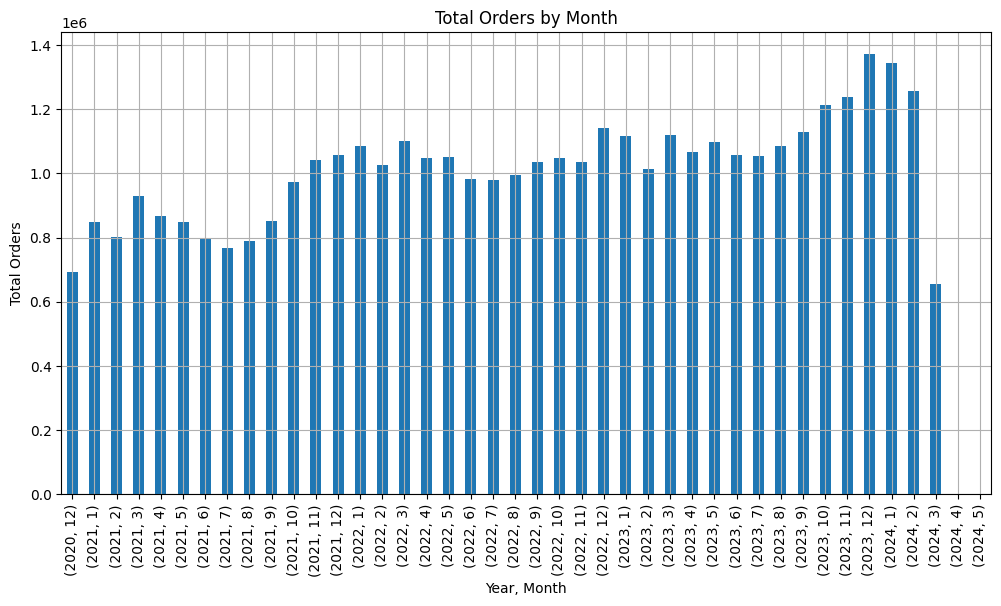

In [25]:
# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()

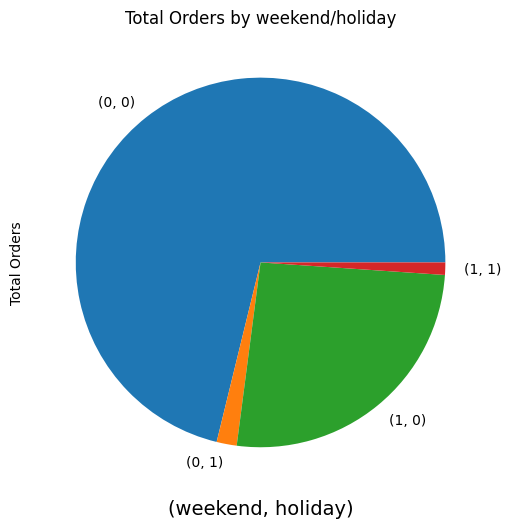

In [26]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

#### Compare feature Colerations

In [30]:
train_df_corr = train_df.drop(columns=['warehouse', "id", 'holiday_name']).corr()
#train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

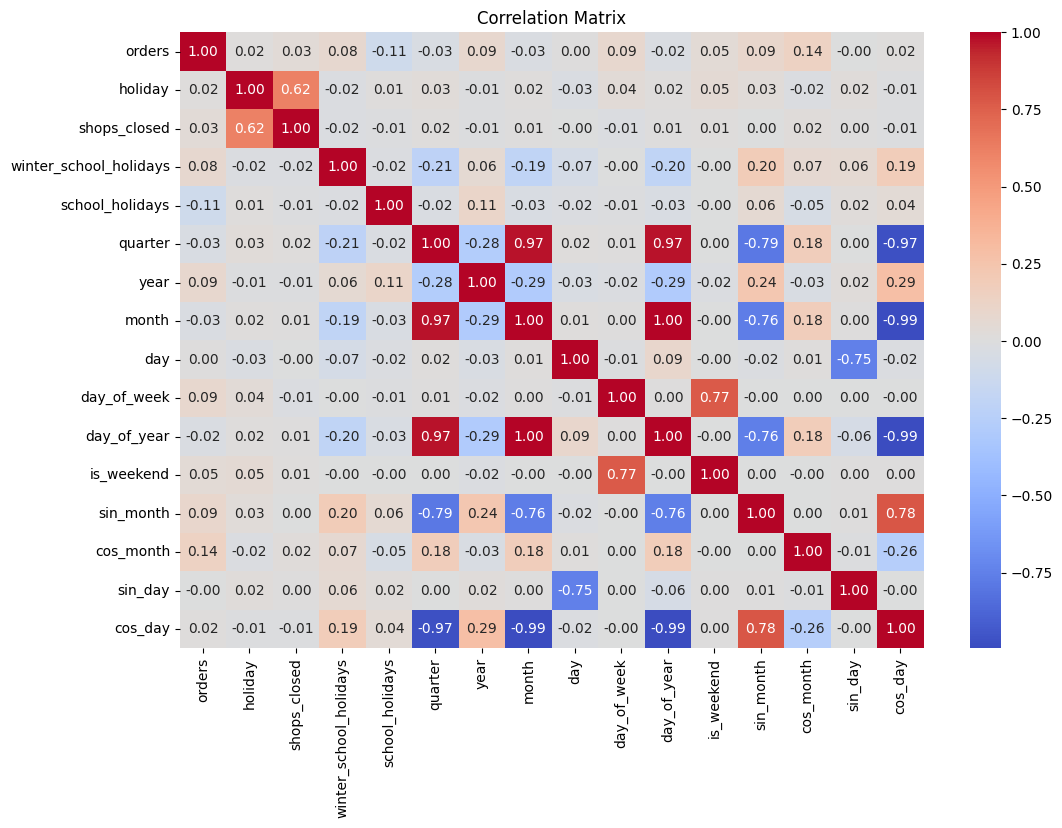

orders                    1.000000
cos_month                 0.142166
sin_month                 0.093846
day_of_week               0.086522
year                      0.085920
winter_school_holidays    0.077211
is_weekend                0.046594
shops_closed              0.034824
holiday                   0.018006
cos_day                   0.017822
day                       0.002689
sin_day                  -0.004039
day_of_year              -0.024332
month                    -0.025271
quarter                  -0.029323
school_holidays          -0.105071
Name: orders, dtype: float64


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Remove Outliers

In [32]:

Q1 = train_df['orders'].quantile(0.25)
Q3 = train_df['orders'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 2.1 * IQR


iqr_outliers = train_df[(train_df['orders'] < lower_bound) | (train_df['orders'] > upper_bound)]

# Print number of outliers identified by each method
print(f"Number of IQR outliers: {iqr_outliers.shape[0]}")

iqr_outliers.head()


Number of IQR outliers: 5


,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,sin_month,cos_month,sin_day,cos_day
date,,,,,,,,,,,,,,,,,,,
2022-12-22,Prague_1,12661.0,NaN,0,0,0,0,Prague_1_2022-12-22,4,2022,12,22,3,356,0,-2.449294e-16,1.0,-0.994522,-0.809017
2022-12-23,Prague_1,13028.0,NaN,0,0,0,0,Prague_1_2022-12-23,4,2022,12,23,4,357,0,-2.449294e-16,1.0,-0.994522,-0.809017
2023-12-21,Prague_1,12744.0,NaN,0,0,0,0,Prague_1_2023-12-21,4,2023,12,21,3,355,0,-2.449294e-16,1.0,-0.951057,-0.809017
2023-12-22,Prague_1,17282.0,NaN,0,0,0,0,Prague_1_2023-12-22,4,2023,12,22,4,356,0,-2.449294e-16,1.0,-0.994522,-0.809017
2023-12-23,Prague_1,18139.0,NaN,0,0,0,0,Prague_1_2023-12-23,4,2023,12,23,5,357,1,-2.449294e-16,1.0,-0.994522,-0.809017


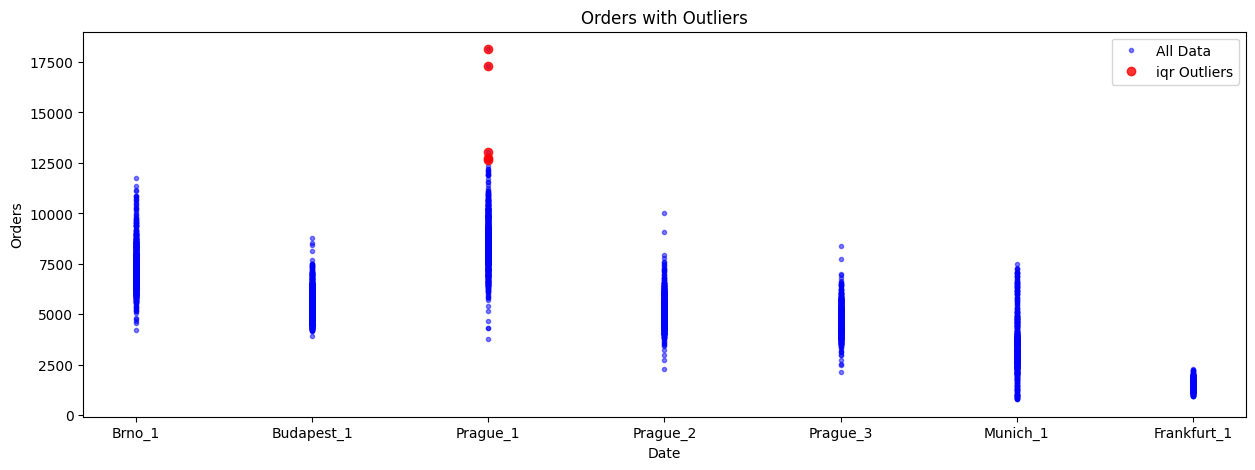

In [33]:
# Plot all data points
plt.figure(figsize=(15, 5))
plt.plot(train_df.warehouse, train_df['orders'], 'b.', alpha=0.5, label='All Data')

# Highlight outliers
plt.plot(iqr_outliers.warehouse, iqr_outliers['orders'], 'ro', alpha=0.8, label='iqr Outliers')


# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Orders with Outliers')
plt.legend()
plt.show()

In [34]:
# Drop outliers
#train_df = train_df.drop(iqr_outliers.index)

# do not drop outliers but fix their values to be average
train_df.loc[iqr_outliers.index, 'orders'] = train_df['orders'].mean()

#### Time Series Cross Validation



In [35]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=398, gap=1) # gap - 24house between train gata end - test data start
cross_val_train_df = train_df.sort_index()

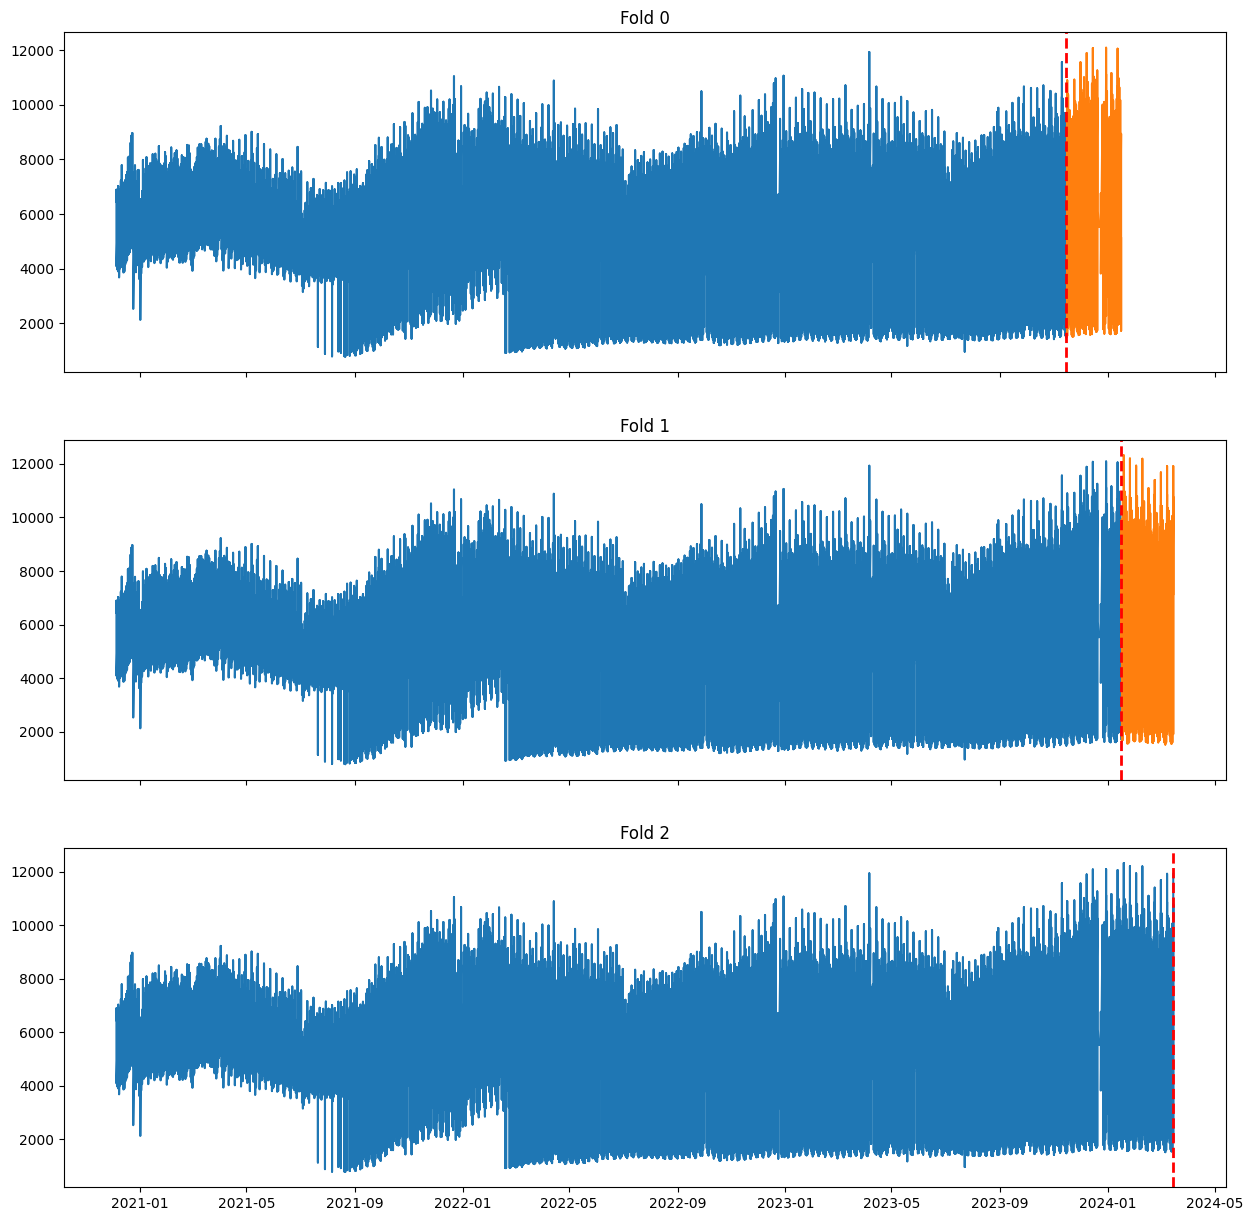

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, test_idx in tss.split(cross_val_train_df):
    train = cross_val_train_df.iloc[train_idx]
    test = cross_val_train_df.iloc[test_idx]
    
    ax[fold].plot(train.index, train['orders'], label='Train')
    ax[fold].plot(test.index, test['orders'], label='Test')
    ax[fold].set_title(f"Fold {fold}")
    ax[fold].axvline(train.index[-1], color='r', linestyle='--', lw=2)
    
    fold += 1

plt.show()

In [37]:
# get df for every warehouse
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]

### Temporal features

In [38]:
train_df.head()

,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,sin_month,cos_month,sin_day,cos_day
date,,,,,,,,,,,,,,,,,,,
2020-12-05,Brno_1,6447.0,NaN,0,0,0,0,Brno_1_2020-12-05,4,2020,12,5,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017
2020-12-05,Budapest_1,4623.0,NaN,0,0,0,0,Budapest_1_2020-12-05,4,2020,12,5,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017
2020-12-05,Prague_1,6895.0,NaN,0,0,0,0,Prague_1_2020-12-05,4,2020,12,5,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017
2020-12-05,Prague_2,4154.0,NaN,0,0,0,0,Prague_2_2020-12-05,4,2020,12,5,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017
2020-12-05,Prague_3,4091.0,NaN,0,0,0,0,Prague_3_2020-12-05,4,2020,12,5,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017


In [39]:
LAG_DAYS = [98, 196, 364]
ROLLING_WINDOW = [98, 364]

In [ ]:
# Create lag features
def create_lag_features(df, col, lag_days):
    lag_features = []
    # create lag features for each warehouse, stop at the last dataset day even if the lag is not complete
    for lag in lag_days:
        df[f'{col}_lag_{lag}'] = df.groupby('warehouse')[col].shift(lag)
        lag_features.append(f'{col}_lag_{lag}')
    return df, lag_features


# Create rolling statistics
def create_rolling_features(df, col, windows):
    window_features = []
    # create rolling features for each warehouse, stop at the last dataset day even if the lag is not complete
    for window in windows:
        df[f'{col}_rolling_mean_{window}'] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[f'{col}_rolling_std_{window}'] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
        window_features.extend([f'{col}_rolling_mean_{window}', f'{col}_rolling_std_{window}'])
    return df, window_features


In [40]:
# Apply the functions
#train_df, lag_features = create_lag_features(train_df, 'orders', LAG_DAYS)
#train_df, window_features = create_rolling_features(train_df, 'orders', ROLLING_WINDOW)

# Combine the features for easier visualization
numerical_features = ['orders']
#numerical_features += lag_features + window_features
categorical_features=categorical_features + ['warehouse', 'holiday_name']

print(numerical_features)

train_df.head()

['orders']


,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,sin_month,cos_month,sin_day,cos_day
date,,,,,,,,,,,,,,,,,,,
2020-12-05,Brno_1,6447.0,NaN,0,0,0,0,Brno_1_2020-12-05,4,2020,12,5,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017
2020-12-05,Budapest_1,4623.0,NaN,0,0,0,0,Budapest_1_2020-12-05,4,2020,12,5,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017
2020-12-05,Prague_1,6895.0,NaN,0,0,0,0,Prague_1_2020-12-05,4,2020,12,5,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017
2020-12-05,Prague_2,4154.0,NaN,0,0,0,0,Prague_2_2020-12-05,4,2020,12,5,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017
2020-12-05,Prague_3,4091.0,NaN,0,0,0,0,Prague_3_2020-12-05,4,2020,12,5,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017


TypeError: 'Axes' object is not subscriptable

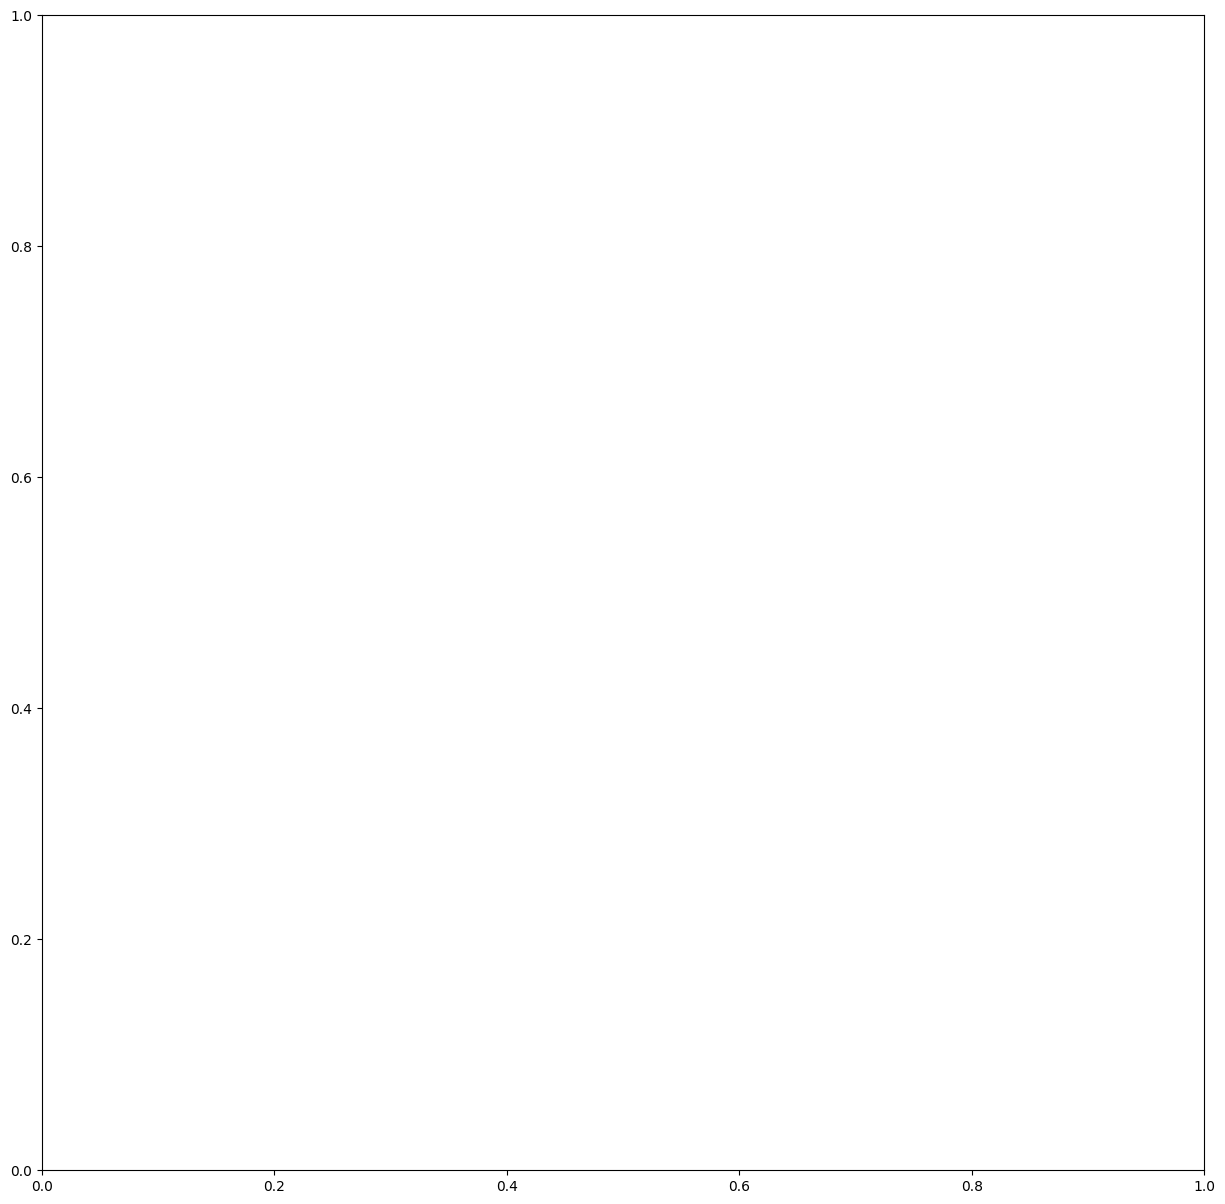

In [41]:
#orders and features above each other
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(15, 15), sharex=True)
for i, feature in enumerate(numerical_features):
    ax[i].plot(train_df.index, train_df['orders'], label='Orders', color='black')
    ax[i].plot(train_df.index, train_df[feature], label=feature)
    ax[i].set_title(feature)
    ax[i].legend()
plt.show()


KeyError: 'orders_lag_364'

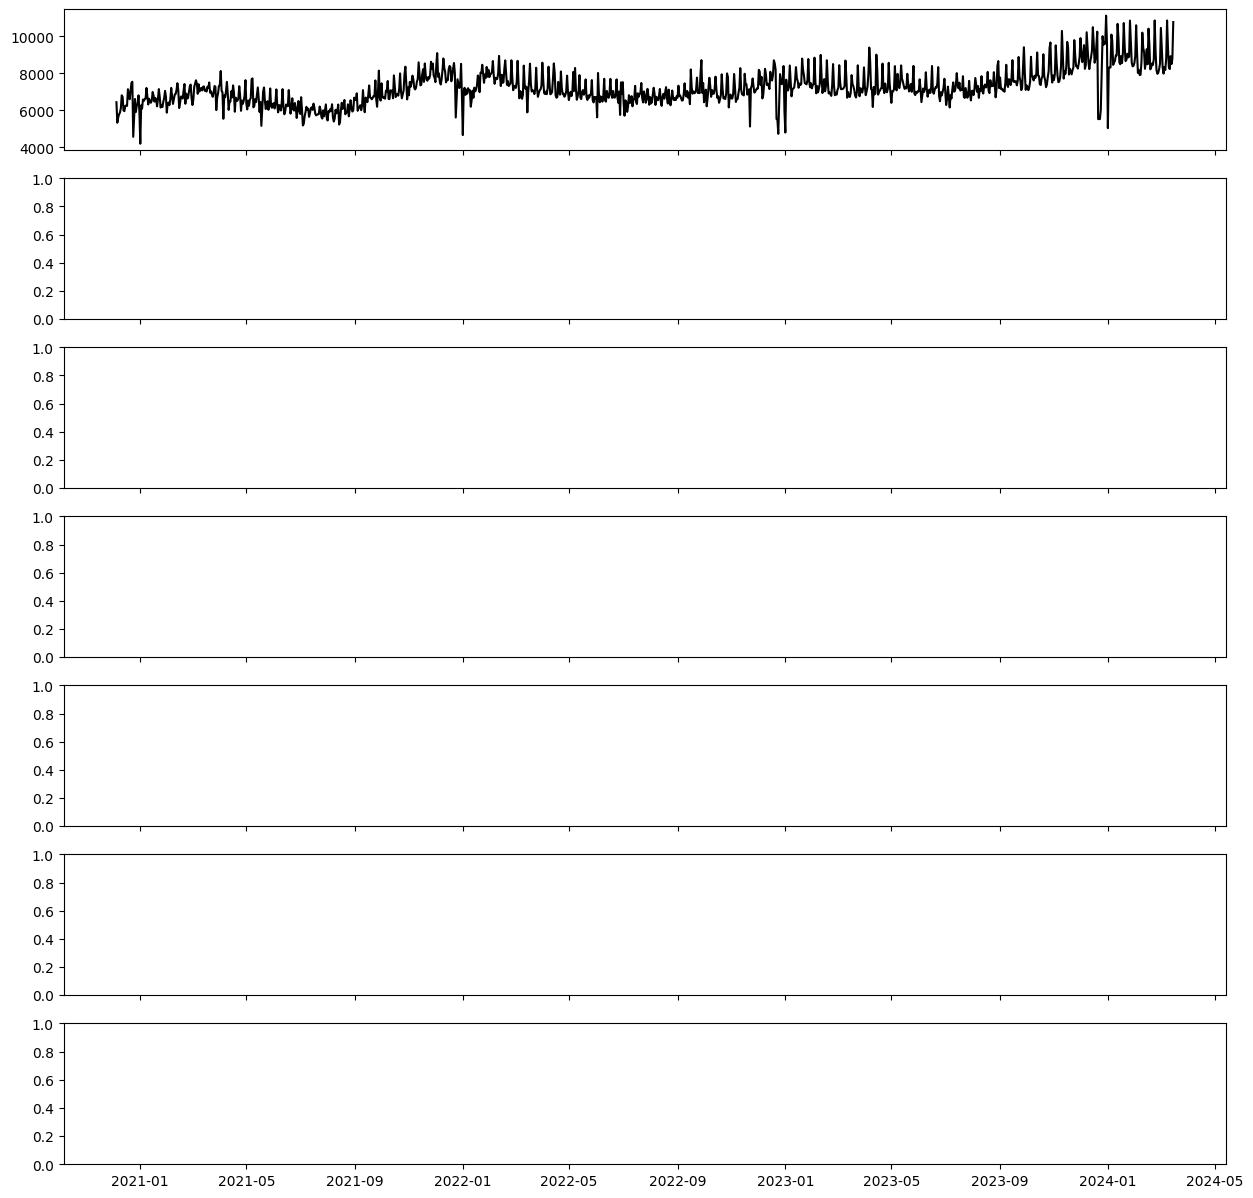

In [ ]:
# make plots for every warehouse with with lag 98 feature
feature = 'orders_lag_364'

fig, ax = plt.subplots(len(train_df['warehouse'].unique()), 1, figsize=(15, 15), sharex=True)
for i, warehouse in enumerate(train_df['warehouse'].unique()):
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    ax[i].plot(warehouse_df.index, warehouse_df['orders'], label='Orders', color='black')
    ax[i].plot(warehouse_df.index, warehouse_df[feature], label=feature)
    ax[i].set_title(warehouse)
    ax[i].legend()
plt.show()

In [42]:
# divide dataset back into train and test datasets according to the dates from the original datasets:
test_date_range = (test_df_merged.date.min(), test_df_merged.date.max())
train_date_range = (train_df_merged.date.min(), train_df_merged.date.max())

test_df = train_df.loc[(train_df.index >= test_date_range[0]) & (train_df.index <= test_date_range[1])]
test_df["date"] = test_df.index
test_df = test_df.drop(columns=['orders'])
train_df = train_df.loc[(train_df.index >= train_date_range[0]) & (train_df.index <= train_date_range[1])]

C:\Users\ondre\AppData\Local\Temp\ipykernel_18492\1761043157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["date"] = test_df.index


In [43]:
train_df.tail()

,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,sin_month,cos_month,sin_day,cos_day
date,,,,,,,,,,,,,,,,,,,
2024-03-15,Frankfurt_1,1916.0,NaN,0,0,0,0,Frankfurt_1_2024-03-15,1,2024,3,15,4,75,0,1.0,6.123234e-17,5.665539e-16,0.809017
2024-03-15,Munich_1,6512.0,NaN,0,0,0,0,Munich_1_2024-03-15,1,2024,3,15,4,75,0,1.0,6.123234e-17,5.665539e-16,0.809017
2024-03-15,Prague_1,11917.0,NaN,0,0,0,0,Prague_1_2024-03-15,1,2024,3,15,4,75,0,1.0,6.123234e-17,5.665539e-16,0.809017
2024-03-15,Prague_2,7140.0,NaN,0,0,0,0,Prague_2_2024-03-15,1,2024,3,15,4,75,0,1.0,6.123234e-17,5.665539e-16,0.809017
2024-03-15,Prague_3,6408.0,NaN,0,0,0,0,Prague_3_2024-03-15,1,2024,3,15,4,75,0,1.0,6.123234e-17,5.665539e-16,0.809017


In [44]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 19)
Test data: (397, 19)


In [45]:
test_df.to_csv('data/test_proc.csv')

In [46]:
train_df = train_df.drop(columns=['id'])

### OH encoding of categorical features

In [47]:
from sklearn.preprocessing import OneHotEncoder
import joblib

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit the encoder on 'warehouse' and 'holiday_name' columns
encoded_features = encoder.fit_transform(train_df[categorical_features])

# Get the encoded feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
    
# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

if 'holiday_name_nan' in encoded_df.columns:
    encoded_df = encoded_df.drop(columns=['holiday_name_nan'])
    encoded_feature_names = encoded_feature_names.tolist()
    encoded_feature_names.remove('holiday_name_nan')
print(encoded_feature_names)    

encoded_df.index = train_df.index

# Concatenate the encoded features with the original DataFrame
train_df = pd.concat([train_df, encoded_df], axis=1)

# Save the encoder
joblib.dump(encoder, 'scaler_onehot_categorical.joblib')

['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'warehouse_Brno_1', 'warehouse_Budapest_1', 'warehouse_Frankfurt_1', 'warehouse_Munich_1', 'warehouse_Prague_1', 'warehouse_Prague_2', 'warehouse_Prague_3', 'holiday_name_1848 Revolution Memorial Day (Extra holiday)', 'holiday_name_2nd Christmas Day', "holiday_name_All Saints' Day Holiday", 'holiday_name_Christmas Eve', 'holiday_name_Cyrila a Metodej', 'holiday_name_Day of National Unity', 'holiday_name_Den boje za svobodu a demokracii', 'holiday_name_Den ceske statnosti', 'holiday_name_Den osvobozeni', 'holiday_name_Den vzniku samostatneho ceskoslovenskeho statu', 'holiday_name_Easter Monday', 'holiday_name_Good Friday', 'holiday_name_Independent Hungary Day', 'holiday_name_International womens day', 'holiday_name_Jan Hus', 'holiday_name_Labour Day', 'holiday_name_Memorial Day for the Martyrs of Arad', 'holiday_name

c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['scaler_onehot_categorical.joblib']

In [48]:
train_df= train_df.drop(columns=categorical_features)

In [49]:
train_df.head()

,orders,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,day,day_of_year,is_weekend,sin_month,cos_month,sin_day,cos_day,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,6447.0,0,0,0,0,2020,12,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-05,4623.0,0,0,0,0,2020,12,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-05,6895.0,0,0,0,0,2020,12,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-05,4154.0,0,0,0,0,2020,12,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-05,4091.0,0,0,0,0,2020,12,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# plot the train and test datasets and visualise them in diferent colors for only column of prague_1 warehouse
plt.figure(figsize=(15, 5)) 
datax = train_df[train_df['warehouse_Budapest_1'] == 1]
datax_test = test_df[test_df['warehouse'] == 'Budapest_1']
plt.plot(datax.index, datax['orders_lag_98'], label='Train', color='blue')
plt.plot(datax.index, datax['orders'], label='Train', color='green')
plt.plot(datax_test.index, datax_test['orders_lag_98'], label='Test', color='red')


plt.title('Train and Test for Prague_1 warehouse LAG 98')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()

KeyError: 'orders_lag_98'

<Figure size 1500x500 with 0 Axes>

### Min-Max scale numerical features

In [50]:
train_df.head()

,orders,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,day,day_of_year,is_weekend,sin_month,cos_month,sin_day,cos_day,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,6447.0,0,0,0,0,2020,12,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-05,4623.0,0,0,0,0,2020,12,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-05,6895.0,0,0,0,0,2020,12,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-05,4154.0,0,0,0,0,2020,12,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-05,4091.0,0,0,0,0,2020,12,5,340,1,-2.449294e-16,1.0,0.866025,-0.809017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
print(f"numerical_features: {numerical_features}")
print(f"time_features: {time_features}")

numerical_features: ['orders']
time_features: ['year', 'month', 'day', 'day_of_year', 'sin_month', 'cos_month', 'sin_day', 'cos_day']


In [52]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
num_scaler = MinMaxScaler()
date_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit the scaler on the numerical columns
train_df[numerical_features] = num_scaler.fit_transform(train_df[numerical_features])
train_df[time_features] = date_scaler.fit_transform(train_df[time_features])

# Save the scaler
joblib.dump(num_scaler, 'scaler_minmax_numerical.joblib')
joblib.dump(date_scaler, 'scaler_minmax_date.joblib')

['scaler_minmax_date.joblib']

In [53]:
# Save all scaler features into singe json scaler config file:
scaler_config = {
    'num_features': numerical_features,
    'cat_features': categorical_features,
    'time_features': time_features,
}

joblib.dump(scaler_config, 'scaler_config.joblib')

['scaler_config.joblib']

In [54]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 56)
Test data: (397, 19)


In [55]:
print(train_df.isna().sum())  # Check for Nas

orders                                                                      0
holiday                                                                     0
shops_closed                                                                0
winter_school_holidays                                                      0
school_holidays                                                             0
year                                                                        0
month                                                                       0
day                                                                         0
day_of_year                                                                 0
is_weekend                                                                  0
sin_month                                                                   0
cos_month                                                                   0
sin_day                                                         

In [56]:
train_df = train_df.fillna(0)

In [ ]:
"""drop nan values of these columns 
orders_lag_98                                                                
orders_lag_196                                                             
orders_lag_364                                                              
orders_rolling_mean_98                                                         
orders_rolling_std_98                                                          
orders_rolling_mean_364                                                        
orders_rolling_std_364     
"""
#train_df = train_df.dropna(subset=['orders_lag_98', 'orders_lag_196', 'orders_lag_364', 'orders_rolling_mean_98', 'orders_rolling_std_98', 'orders_rolling_mean_364', 'orders_rolling_std_364'])
                                                    

'drop nan values of these columns \norders_lag_98                                                                \norders_lag_196                                                             \norders_lag_364                                                              \norders_rolling_mean_98                                                         \norders_rolling_std_98                                                          \norders_rolling_mean_364                                                        \norders_rolling_std_364     \n'

In [57]:
train_df.describe()

,orders,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,day,day_of_year,is_weekend,sin_month,cos_month,sin_day,cos_day,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3,holiday_name_1848 Revolution Memorial Day (Extra holiday),holiday_name_2nd Christmas Day,holiday_name_All Saints' Day Holiday,holiday_name_Christmas Eve,holiday_name_Cyrila a Metodej,holiday_name_Day of National Unity,holiday_name_Den boje za svobodu a demokracii,holiday_name_Den ceske statnosti,holiday_name_Den osvobozeni,holiday_name_Den vzniku samostatneho ceskoslovenskeho statu,holiday_name_Easter Monday,holiday_name_Good Friday,holiday_name_Independent Hungary Day,holiday_name_International womens day,holiday_name_Jan Hus,holiday_name_Labour Day,holiday_name_Memorial Day for the Martyrs of Arad,holiday_name_Memorial Day for the Victims of the Communist Dictatorships,holiday_name_Memorial Day for the Victims of the Holocaust,holiday_name_Memorial Day of the Republic,holiday_name_National Defense Day,holiday_name_New Years Day,holiday_name_Peace Festival in Augsburg,holiday_name_Reformation Day
count,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.00000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000
mean,0.410539,0.027248,0.010899,0.029973,0.007084,0.541928,0.489002,0.489237,0.486480,0.262534,0.514897,0.527253,0.506410,0.550348,0.144414,0.147820,0.149046,0.148365,0.147820,0.147820,0.114714,0.286921,0.223025,0.23624,0.253815,0.162534,0.157221,0.085695,0.106948,0.162534,0.162534,0.162534,0.000136,0.002180,0.000136,0.003134,0.001635,0.000409,0.001635,0.001635,0.001635,0.001635,0.001635,0.001635,0.000409,0.003542,0.001635,0.001635,0.000409,0.000545,0.000409,0.000545,0.000409,0.002180,0.000272,0.000272
std,0.187283,0.162816,0.103836,0.170524,0.083876,0.237950,0.326135,0.292162,0.300385,0.440041,0.352709,0.353081,0.353493,0.349661,0.351533,0.354946,0.356158,0.355486,0.354946,0.354946,0.318698,0.452355,0.416303,0.42480,0.435222,0.368965,0.364034,0.279932,0.309068,0.368965,0.368965,0.368965,0.011672,0.046641,0.011672,0.055894,0.040403,0.020214,0.040403,0.040403,0.040403,0.040403,0.040403,0.040403,0.020214,0.059415,0.040403,0.040403,0.020214,0.023340,0.020214,0.023340,0.020214,0.046641,0.016506,0.016506
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.316311,0.000000,0.000000,0.000000,0.000000,0.250000,0.181818,0.233333,0.205479,0.000000,0.250000,0.250000,0.126381,0.172909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [58]:
# check non-continuos date timeline
train_df.index.to_series().diff().value_counts()

date
0 days    6147
1 days    1188
2 days       4
Name: count, dtype: int64

### Create Time Series 

In [59]:
X_train = train_df.drop(columns=['orders'])
y_train = train_df['orders']

In [60]:
X_train.shape, y_train.shape

((7340, 55), (7340,))

In [61]:
def get_lstm(df, target, timestamps):
    X = []
    y = []
    for i in range(timestamps, len(df)):
        X.append(df.iloc[i-timestamps:i].values)
        y.append(target.iloc[i])
    return np.array(X), np.array(y)

# Get the LSTM data
X, y = get_lstm(X_train, y_train, 28)

X.shape, y.shape

((7312, 28, 55), (7312,))

In [60]:
def prepare_data_for_lstm(df, target_col_index, n_timesteps):
    X, y = [], []
    for i in range(n_timesteps, len(df)):
        X.append(df.iloc[i-n_timesteps:i, :].values)
        y.append(df.iloc[i, target_col_index])
    return np.array(X), np.array(y)

# Define the number of timesteps (sequence length)
n_timesteps = 98

# Prepare training sequences
X, y = prepare_data_for_lstm(X_train, train_df.columns.get_loc('orders'), n_timesteps)

print(f"X shape: {X.shape}") 
print(f"y shape: {y.shape}") 

X shape: (4694, 98, 24)
y shape: (4694,)


In [61]:
def create_datset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 28
X, y = create_datset(X_train, y_train, time_steps)

print(f"X shape: {X.shape}") 
print(f"y shape: {y.shape}") 

X shape: (4764, 28, 24)
y shape: (4764,)


### Data Loading

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)

### Compile and Fit the model

In [63]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

LR = 1e-3
checkpointing = tf.keras.callbacks.ModelCheckpoint('best_model_lstm.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LR))

history = model.fit(X_train, y_train, epochs=5, batch_size=8, verbose=1, validation_data=(X_val, y_val), callbacks=[checkpointing])

Epoch 1/5
823/823 [==============================] - ETA: 0s - loss: 0.0301
Epoch 1: val_loss improved from inf to 0.02355, saving model to best_model_lstm.h5
823/823 [==============================] - 189s 226ms/step - loss: 0.0301 - val_loss: 0.0235
Epoch 2/5
823/823 [==============================] - ETA: 0s - loss: 0.0131
Epoch 2: val_loss did not improve from 0.02355
823/823 [==============================] - 186s 226ms/step - loss: 0.0131 - val_loss: 0.0247
Epoch 3/5
823/823 [==============================] - ETA: 0s - loss: 0.0083
Epoch 3: val_loss improved from 0.02355 to 0.01403, saving model to best_model_lstm.h5
823/823 [==============================] - 186s 226ms/step - loss: 0.0083 - val_loss: 0.0140
Epoch 4/5
823/823 [==============================] - ETA: 0s - loss: 0.0055
Epoch 4: val_loss improved from 0.01403 to 0.01047, saving model to best_model_lstm.h5
823/823 [==============================] - 185s 225ms/step - loss: 0.0055 - val_loss: 0.0105
Epoch 5/5
823/823 [=

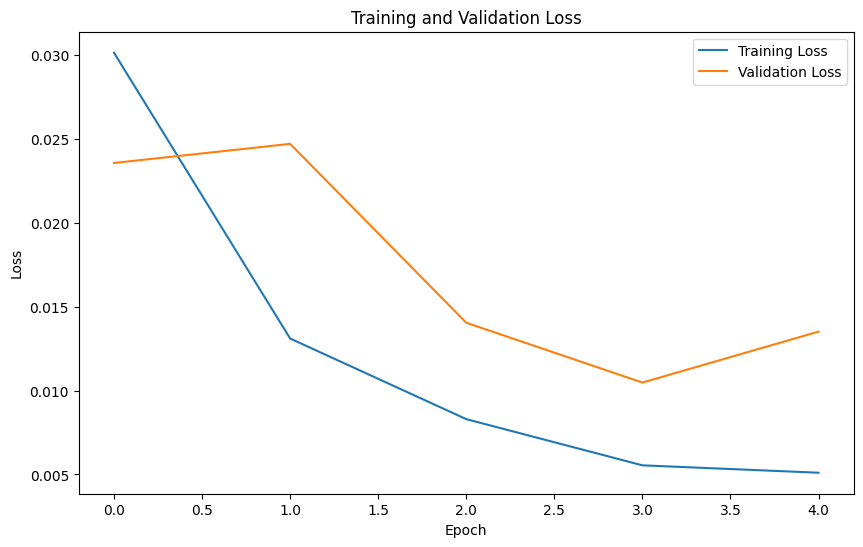

In [66]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Inference

#### MAPE

In [70]:
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf

model = tf.keras.models.load_model('best_model_lstm.h5')

y_pred = model.predict(X_val)

mape = mean_absolute_percentage_error(y_val, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')

23/23 [==============================] - 1s 34ms/step
Mean Absolute Percentage Error (MAPE): 19.11%


In [88]:
import pandas as pd
import joblib

dataframe = pd.read_csv("data/test_proc.csv")

In [89]:
loaded_oh_encoder = joblib.load('scaler_onehot_categorical.joblib')
loaded_num_scaler = joblib.load('scaler_minmax_numerical.joblib')
loaded_date_scaler = joblib.load('scaler_minmax_date.joblib')

In [90]:
dataframe.head(10)

,date,warehouse,orders,holiday,shops_closed,id,school_holiday,quarter,year,month,...,day_of_year,day_of_week,is_weekend,orders_lag_98,orders_lag_196,orders_lag_364,orders_rolling_mean_98,orders_rolling_std_98,orders_rolling_mean_364,orders_rolling_std_364
0,2024-03-16,Brno_1,NaN,0,0,Brno_1_2024-03-16,0,1,2024,3,...,76,5,1,10226.0,7783.0,7910.0,8874.158058,1124.113158,7923.549123,1038.261319
1,2024-03-16,Budapest_1,NaN,0,0,Budapest_1_2024-03-16,0,1,2024,3,...,76,5,1,6769.0,5373.0,6047.0,6647.859089,475.779268,6119.761244,552.134147
2,2024-03-16,Frankfurt_1,NaN,0,0,Frankfurt_1_2024-03-16,0,1,2024,3,...,76,5,1,1777.0,1409.0,1354.0,1905.013728,678.366221,1649.499536,402.229296
3,2024-03-16,Munich_1,NaN,0,0,Munich_1_2024-03-16,0,1,2024,3,...,76,5,1,6710.0,2891.0,2448.0,5684.158058,884.763406,4126.981630,1304.648225
4,2024-03-16,Prague_1,NaN,0,0,Prague_1_2024-03-16,0,1,2024,3,...,76,5,1,11892.0,9169.0,9817.0,10053.003419,1282.256618,9168.708903,1135.970268
5,2024-03-16,Prague_2,NaN,0,0,Prague_2_2024-03-16,0,1,2024,3,...,76,5,1,7135.0,5496.0,5901.0,6112.271460,628.716150,5541.193751,644.926369
6,2024-03-16,Prague_3,NaN,0,0,Prague_3_2024-03-16,0,1,2024,3,...,76,5,1,6480.0,5085.0,5207.0,5484.962182,560.099532,5047.033971,549.088483
7,2024-03-17,Brno_1,NaN,0,0,Brno_1_2024-03-17,0,1,2024,3,...,77,6,1,9400.0,7165.0,7432.0,8868.680538,1128.712017,7924.906993,1039.375544
8,2024-03-17,Budapest_1,NaN,0,0,Budapest_1_2024-03-17,0,1,2024,3,...,77,6,1,6480.0,5889.0,5635.0,6649.607621,477.963413,6121.100364,552.307733
9,2024-03-17,Prague_1,NaN,0,0,Prague_1_2024-03-17,0,1,2024,3,...,77,6,1,10843.0,8184.0,8544.0,10044.774288,1286.410263,9170.434618,1137.065962


In [91]:
# load scaler config:
scaler_config = joblib.load('scaler_config.joblib')

num_features = scaler_config['num_features']
cat_features = scaler_config['cat_features']
time_features = scaler_config['time_features']
    
print(f"num_features: {num_features}")
print(f"cat_features: {cat_features}")
print(f"time_features: {time_features}")

num_features: ['orders_lag_98', 'orders_lag_196', 'orders_lag_364', 'orders_rolling_mean_98', 'orders_rolling_std_98', 'orders_rolling_mean_364', 'orders_rolling_std_364', 'orders']
cat_features: ['warehouse']
time_features: ['quarter', 'year', 'month', 'day', 'day_of_year', 'day_of_week']


In [92]:
from working import preprocess_data

processed_data = preprocess_data(dataframe, cat_features, num_features, time_features, loaded_oh_encoder, loaded_num_scaler, loaded_date_scaler)

In [93]:
processed_data.head()     

,orders,holiday,shops_closed,id,school_holiday,quarter,year,month,day,day_of_year,...,orders_rolling_std_98,orders_rolling_mean_364,orders_rolling_std_364,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3
date,,,,,,,,,,,,,,,,,,,,,
2024-03-16,NaN,0,0,Brno_1_2024-03-16,0,0.0,1.0,0.181818,0.5,0.205479,...,0.871254,0.849230,0.794323,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-16,NaN,0,0,Budapest_1_2024-03-16,0,0.0,1.0,0.181818,0.5,0.205479,...,0.368124,0.631131,0.421904,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-03-16,NaN,0,0,Frankfurt_1_2024-03-16,0,0.0,1.0,0.181818,0.5,0.205479,...,0.525339,0.090623,0.307062,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-03-16,NaN,0,0,Munich_1_2024-03-16,0,0.0,1.0,0.181818,0.5,0.205479,...,0.685510,0.390180,0.998400,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2024-03-16,NaN,0,0,Prague_1_2024-03-16,0,0.0,1.0,0.181818,0.5,0.205479,...,0.993979,0.999785,0.869177,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [94]:
processed_data.shape

(397, 26)

In [65]:
# Compare the columns in the original and processed dataframes

X_columns = set(train_df.columns)
processed_data_columns = set(processed_data.columns)

if X_columns == processed_data_columns:
    print("this df has the same columns as the training df.")
else:
    print("The dataframes have different columns.")

    columns_only_in_X = X_columns - processed_data_columns
    columns_only_in_processed_data = processed_data_columns - X_columns

    if columns_only_in_X:
        print("Columns present only in train_df:")
        print(columns_only_in_X)

    if columns_only_in_processed_data:
        print("Columns present only in processed_data:")
        print(columns_only_in_processed_data)

NameError: name 'train_df' is not defined

In [96]:
id_column = dataframe['id']
warehouse_column = dataframe['warehouse']

processed_data = processed_data.fillna(0)

processed_data = processed_data.drop(['id', 'orders'], axis=1)

In [97]:
id_column.head()

0         Brno_1_2024-03-16
1     Budapest_1_2024-03-16
2    Frankfurt_1_2024-03-16
3       Munich_1_2024-03-16
4       Prague_1_2024-03-16
Name: id, dtype: object

In [98]:
processed_data.head(10)

,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend,...,orders_rolling_std_98,orders_rolling_mean_364,orders_rolling_std_364,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3
date,,,,,,,,,,,,,,,,,,,,,
2024-03-16,0,0,0,0.0,1.0,0.181818,0.500000,0.205479,0.833333,1,...,0.871254,0.849230,0.794323,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-16,0,0,0,0.0,1.0,0.181818,0.500000,0.205479,0.833333,1,...,0.368124,0.631131,0.421904,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-03-16,0,0,0,0.0,1.0,0.181818,0.500000,0.205479,0.833333,1,...,0.525339,0.090623,0.307062,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-03-16,0,0,0,0.0,1.0,0.181818,0.500000,0.205479,0.833333,1,...,0.685510,0.390180,0.998400,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2024-03-16,0,0,0,0.0,1.0,0.181818,0.500000,0.205479,0.833333,1,...,0.993979,0.999785,0.869177,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2024-03-16,0,0,0,0.0,1.0,0.181818,0.500000,0.205479,0.833333,1,...,0.486809,0.561175,0.492991,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-16,0,0,0,0.0,1.0,0.181818,0.500000,0.205479,0.833333,1,...,0.433560,0.501425,0.419570,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2024-03-17,0,0,0,0.0,1.0,0.181818,0.533333,0.208219,1.000000,1,...,0.874823,0.849394,0.795176,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-17,0,0,0,0.0,1.0,0.181818,0.533333,0.208219,1.000000,1,...,0.369819,0.631293,0.422036,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [99]:
processed_data.describe()

,holiday,shops_closed,school_holiday,quarter,year,month,day,day_of_year,day_of_week,is_weekend,...,orders_rolling_std_98,orders_rolling_mean_364,orders_rolling_std_364,warehouse_Brno_1,warehouse_Budapest_1,warehouse_Frankfurt_1,warehouse_Munich_1,warehouse_Prague_1,warehouse_Prague_2,warehouse_Prague_3
count,397.000000,397.000000,397.000000,397.000000,397.0,397.000000,397.000000,397.000000,397.000000,397.000000,...,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,0.068010,0.020151,0.090680,0.247691,1.0,0.271353,0.492863,0.287878,0.476910,0.269521,...,0.541449,0.599949,0.622257,0.153652,0.143577,0.120907,0.120907,0.153652,0.153652,0.153652
std,0.252081,0.140694,0.287516,0.145830,0.0,0.064268,0.288115,0.048259,0.329245,0.444271,...,0.198526,0.270605,0.243473,0.361070,0.351103,0.326430,0.326430,0.361070,0.361070,0.361070
min,0.000000,0.000000,0.000000,0.000000,1.0,0.181818,0.000000,0.205479,0.000000,0.000000,...,0.150096,0.090623,0.307062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.0,0.181818,0.233333,0.246575,0.166667,0.000000,...,0.375654,0.501637,0.423764,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.333333,1.0,0.272727,0.500000,0.287671,0.500000,0.000000,...,0.505565,0.565531,0.497435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.333333,1.0,0.272727,0.733333,0.328767,0.833333,1.000000,...,0.668738,0.853601,0.875519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.333333,1.0,0.363636,1.000000,0.369863,1.000000,1.000000,...,1.030414,1.008083,1.017181,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [100]:
import numpy as np

timestamps = 28

X_infer = []
for i in range(timestamps, len(processed_data)):
    X_infer.append(processed_data.iloc[i-timestamps:i].values)
X_infer = np.array(X_infer)

X_infer.shape

(369, 28, 24)

In [101]:
predictions = model.predict(X_infer)

12/12 [==============================] - 1s 36ms/step


In [102]:
predictions.shape  

(369, 1)

In [103]:
predictions_for_scaler = np.tile(predictions, (1, 8))

In [104]:
predictions_for_scaler.shape  

(369, 8)

In [105]:
predictions_for_scaler

array([[0.06803142, 0.06803142, 0.06803142, ..., 0.06803142, 0.06803142,
        0.06803142],
       [0.3141017 , 0.3141017 , 0.3141017 , ..., 0.3141017 , 0.3141017 ,
        0.3141017 ],
       [0.84896815, 0.84896815, 0.84896815, ..., 0.84896815, 0.84896815,
        0.84896815],
       ...,
       [0.81953126, 0.81953126, 0.81953126, ..., 0.81953126, 0.81953126,
        0.81953126],
       [0.42257923, 0.42257923, 0.42257923, ..., 0.42257923, 0.42257923,
        0.42257923],
       [0.35766613, 0.35766613, 0.35766613, ..., 0.35766613, 0.35766613,
        0.35766613]], dtype=float32)

In [106]:
# Rescale the predictions to original scale:
predictions_rescaled = loaded_num_scaler.inverse_transform(predictions_for_scaler)

#put back to 1S shape from this (369, 8) to (369,)
predictions_rescaled = predictions_rescaled[:, 0].reshape(369, 1)

#put the predictions into the dataframe with "id" and "orders" columns
submission_df = pd.DataFrame({'id': id_column[:369], 'orders': predictions_rescaled.flatten()})

submission_df.to_csv('submission_rescaled.csv', index=False)
submission_df.head()

,id,orders
0,Brno_1_2024-03-16,1548.005981
1,Budapest_1_2024-03-16,4289.721191
2,Frankfurt_1_2024-03-16,10249.203125
3,Munich_1_2024-03-16,5649.302246
4,Prague_1_2024-03-16,4802.311523


In [107]:
# Add the date column as an index and warehouse column to the rescaled predictions 
submission_df['date'] = dataframe['date']
submission_df['warehouse'] = dataframe['warehouse']
submission_df.head(10)

,id,orders,date,warehouse
0,Brno_1_2024-03-16,1548.005981,2024-03-16,Brno_1
1,Budapest_1_2024-03-16,4289.721191,2024-03-16,Budapest_1
2,Frankfurt_1_2024-03-16,10249.203125,2024-03-16,Frankfurt_1
3,Munich_1_2024-03-16,5649.302246,2024-03-16,Munich_1
4,Prague_1_2024-03-16,4802.311523,2024-03-16,Prague_1
5,Prague_2_2024-03-16,8309.073242,2024-03-16,Prague_2
6,Prague_3_2024-03-16,6273.992676,2024-03-16,Prague_3
7,Brno_1_2024-03-17,1885.443604,2024-03-17,Brno_1
8,Budapest_1_2024-03-17,4545.113770,2024-03-17,Budapest_1
9,Prague_1_2024-03-17,10806.900391,2024-03-17,Prague_1


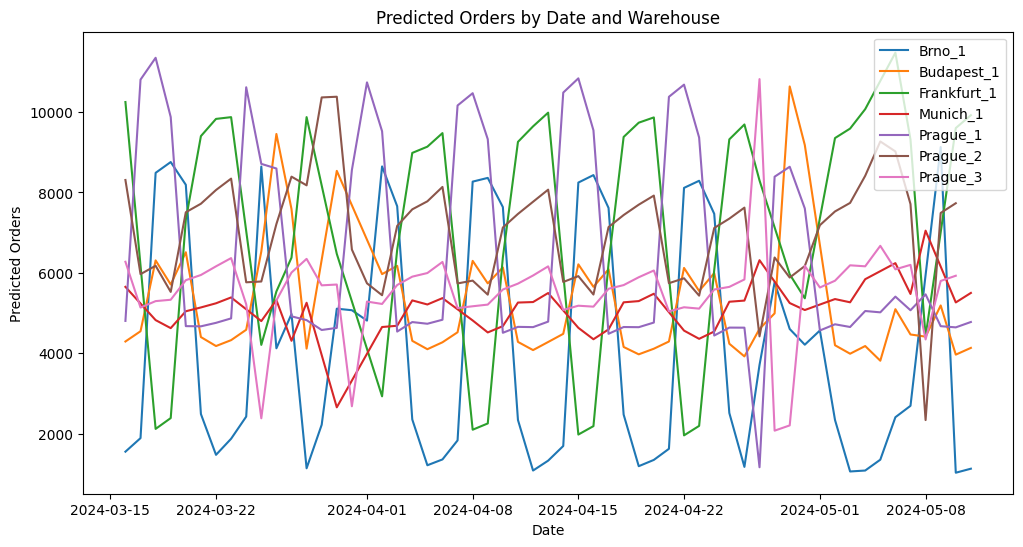

In [108]:
import matplotlib.pyplot as plt
# Visualise rescaled predictions with date for every warehouse on the same plot
warehouses = submission_df['warehouse'].unique()
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df[submission_df['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=wh)
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()

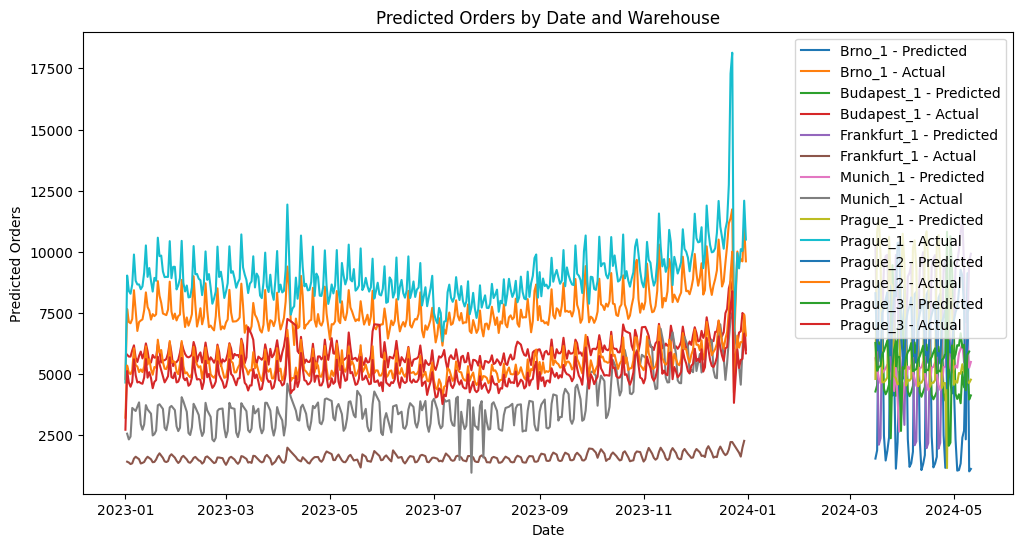

In [112]:
# Visualise the predictions in compare to the same dates in the training data in year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year == 2023]
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df[submission_df['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=f'{wh} - Predicted')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label=f'{wh} - Actual')
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()


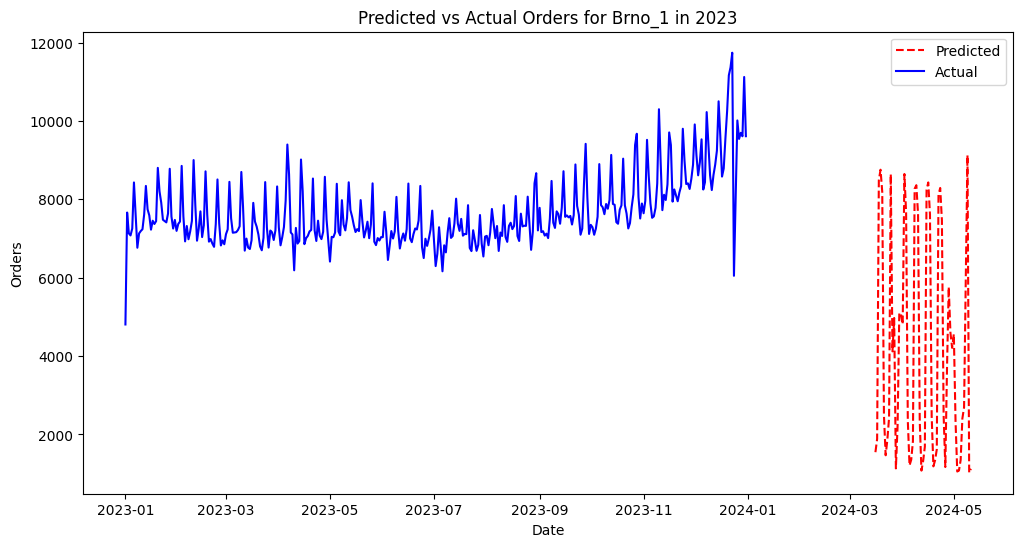

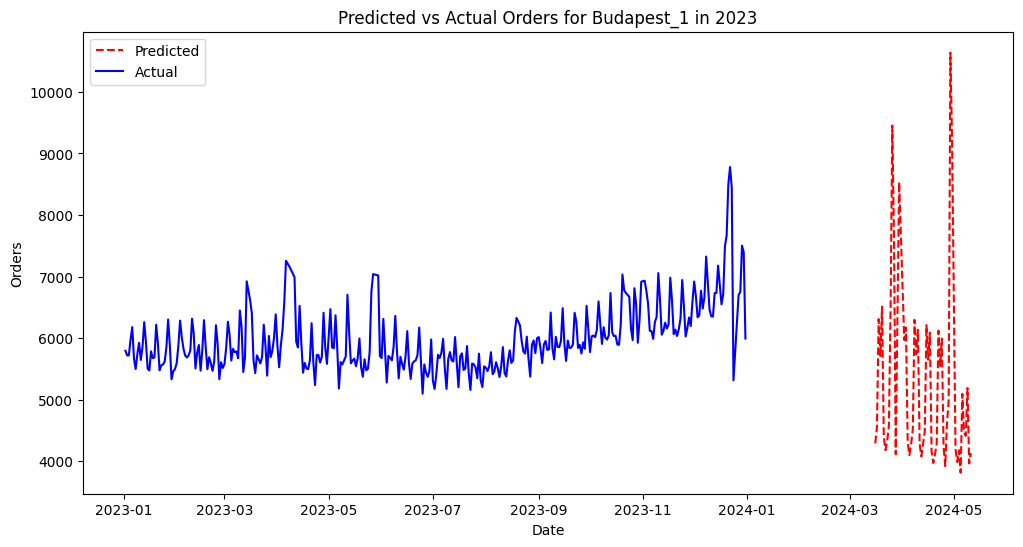

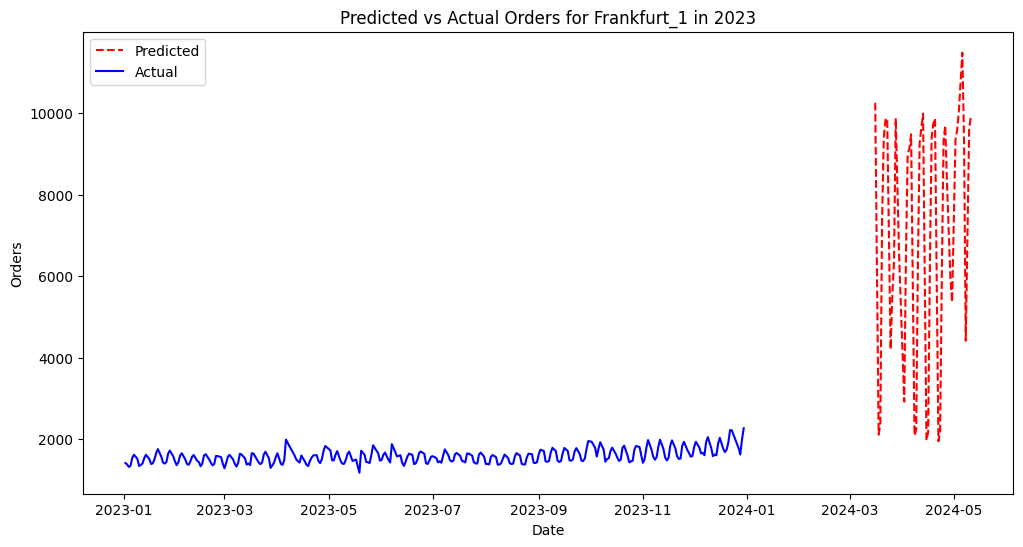

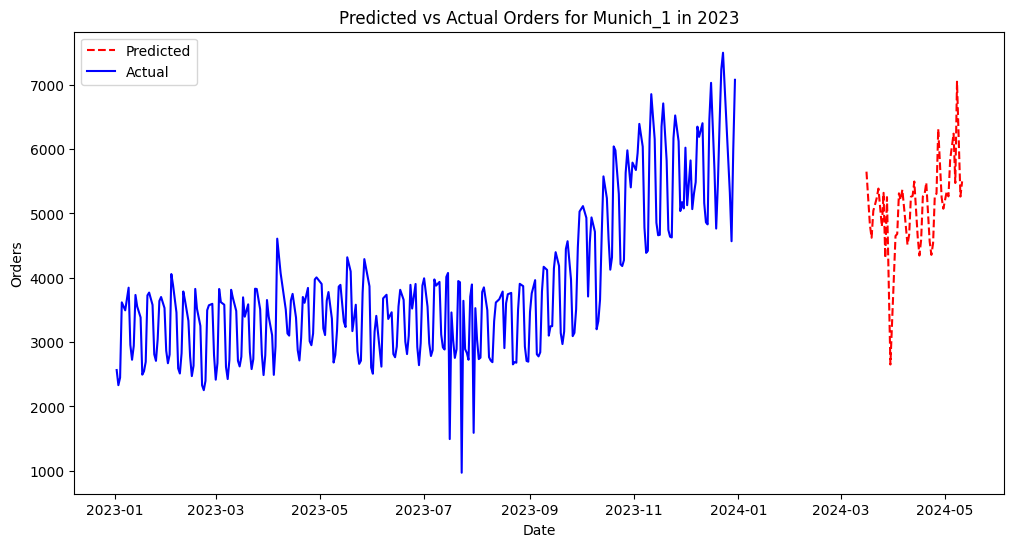

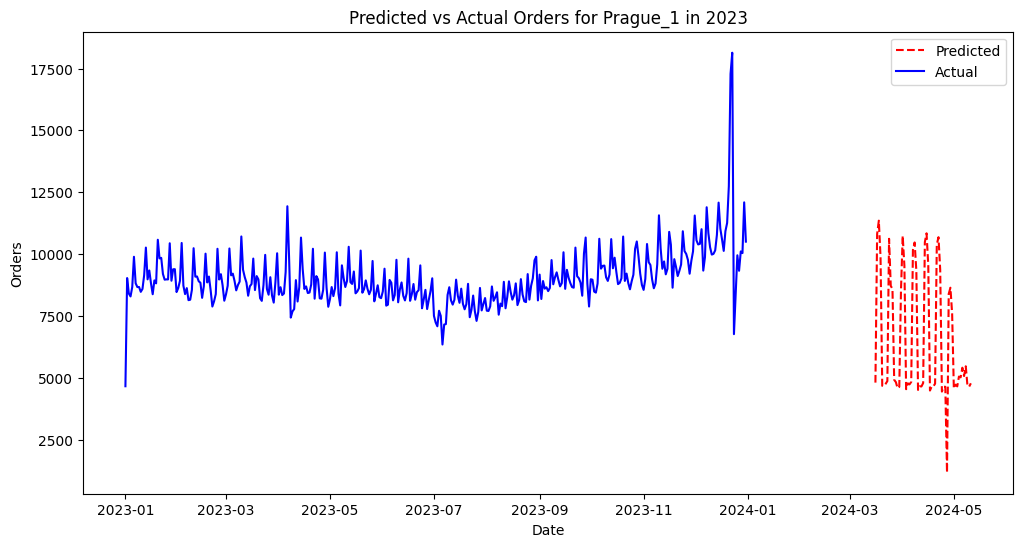

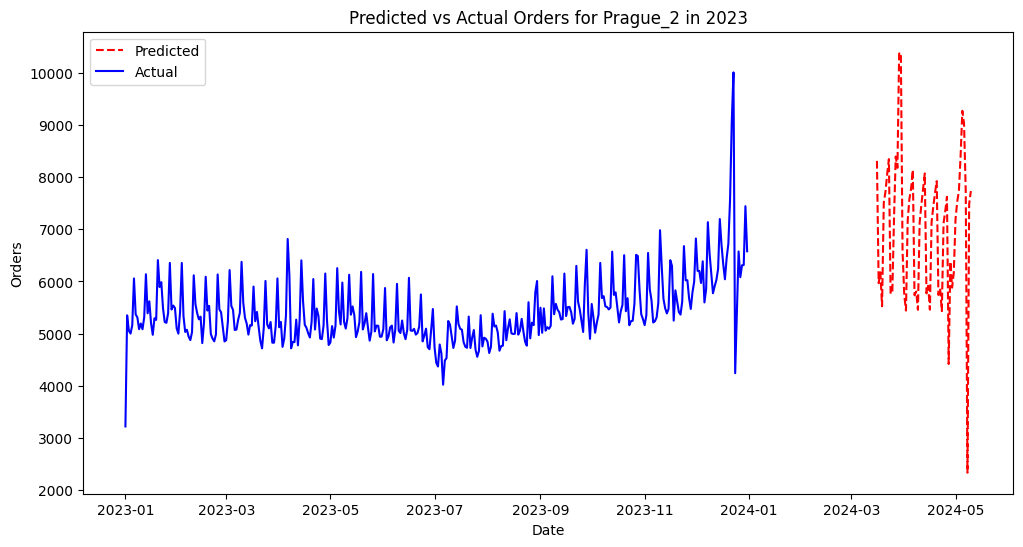

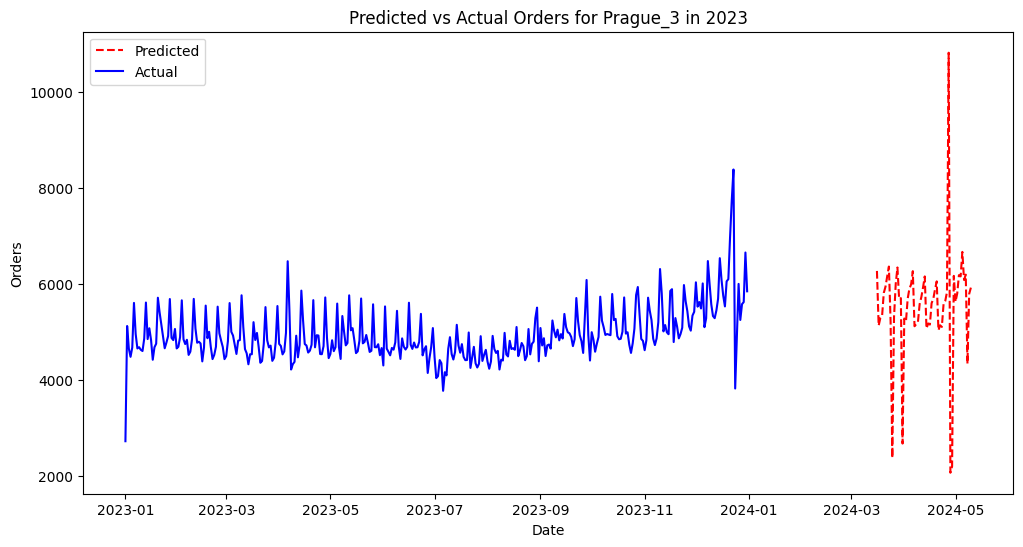

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming these dataframes are already loaded
# train_df_raw: Raw training data
# submission_df_rescaled: Rescaled predictions
# warehouses: List of warehouse names

# Filter training data for the year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year == 2023]

# Create separate plots for each warehouse
for wh in warehouses:
    wh_df = submission_df[submission_df['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    
    plt.figure(figsize=(12, 6))
    plt.plot(wh_df['date'], wh_df['orders'], label='Predicted', linestyle='--', color='r')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label='Actual', color='b')
    plt.title(f'Predicted vs Actual Orders for {wh} in 2023')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
